<h1><center> Final Project: Lập trình song song </center></h1>
<h2><center> Thay đổi kích thước hình ảnh bằng thuật toán Seam Carving </center></h2>


### Danh sách các thành viên

|ID | MSSV     | Họ và tên          |
|---|----------|--------------------|
|1  | 19127353 | Lê Tấn Đạt         |
|2  | 19127530 | Hoàng Đức Quang    |
|3  | 19127391 | Tô Vũ Thái Hào     |

# Utility functions

In [1]:
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  print("Kích thước hình ảnh:", w, "x", h)
  return Image.fromarray(pixels)


In [3]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 7.5


# Application description - Thay đổi kích thước hình ảnh bằng thuật toán Seam Carving

- Ứng dụng được chọn: Seam Carving
 - Nó hoạt động bằng cách tìm ra đường seam ít quan trọng nhất của một hình ảnh và tự động loại bỏ đường seam đó để giảm kích thước hình ảnh hoặc chèn đường nối để mở rộng ảnh. Trong đồ án lần này là thu nhỏ kích thước hình ảnh theo chiều ngang.
 - Mục đích của thuật toán là căn chỉnh lại các vật thể trong ảnh, giúp hiển thị hình ảnh trên nhiều phương tiện khác nhau mà không bị biến dạng các đối tượng quan trọng.
 - **Input**: Một hình ảnh ở định dạng RGB
 - **Output**: Hình ảnh đã được thay đổi kích thước nhưng không làm biến dạng những đối tượng quan trọng (tăng/giảm về chiều rộng và giữ nguyên chiều cao)
 - **Use case**: lập trình web, app di động cần hiển thị một hình ảnh trên nhiều loại thiết bị (responsive)
- **Ứng dụng này có cần tăng tốc không?**
 - Có, ứng dụng rất cần tăng tốc, cụ thể sẽ nói ở phần sau

# Cài đặt tuần tự

## Mô tả thuật toán

Yêu cầu: Thu hẹp chiều rộng ảnh


**Bước 1**: Dùng edge detection để tính độ quan trọng của mỗi pixel
  - Chuyển đổi ảnh RGB thành ảnh grayscale
  - Tính **tích chập (convolution)** giữa ảnh grayscale với bộ lọc x-Sobel *(1)*
$$\begin{bmatrix} 1 & 0 & -1 \\ 2 & 0 & -2 \\ 1 & 0 & -1 \end{bmatrix}$$
  - Tính **tích chập (convolution)** giữa ảnh grayscale với bộ lọc y-Sobel *(2)*
$$\begin{bmatrix} 1 & 2 & 1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$
  - Tính độ quan trọng của một pixel 
```
 Importance của một pixel = |kết quả (1)| + |kết quả (2)|
```

**Bước 2**: Tìm đường **seam** ít quan trọng nhất từ độ quan trọng của pixel
 - Từ độ quan trọng của pixel ở bước 1, tiến hành tính toán các đường **seam** có thể có bằng thuật toán quy hoạch động **bottom-up**. 
 - Giả sử chúng ta cần tính giá trị của đường **seam** tại vị trí *i, j*. Kiểm tra 3 pixel có vị trí lần lược là *i + 1, j - 1*, *i + 1, j*, *i + 1, j + 1*, giá trị nào nhỏ nhất sẽ là giá trị được chọn để cộng thêm vào giá trị hiện có tại vị trí *i, j*:
 $$dp[i][j] = min(dp[i+1][j-1], dp[i+1][j], dp[i+1][j+1]) + dp[i][j]$$

- Ở mỗi bước, cập nhập giá trị của ma trận **trackCol** để lưu vết lại đường đi của mỗi **seam**.
- Tìm đường **seam** nhỏ nhất thông qua việc tìm giá trị nhỏ nhất của hàng đầu tiên của ma trận, từ đó thông qua ma trận **trackCol**, dễ dàng truy vết được đường đi của **seam** đó

**Bước 3**: Xóa Seam ít quan trọng nhất vừa tìm được
- Tính toán vị trí của điểm ảnh hiện tại sẽ trở thành vị trí nào sau khi xóa seam có độ quan trọng ít nhất. Sau đó gán điểm ảnh hiện tại vào vị trí đã được tính toán
- Ghi ảnh đầu ra

*Lặp đi lặp lại các bước trên cho đến khi có được độ rộng mong muốn*

## Tiến hành cài đặt

- Kịch bản thí nghiệm:
 - **File ảnh**: *castle.pnm*
 - **Input**: hình ảnh có kích thước là 640 x 434, số lượng **seam** sẽ xoá đi là 300.
 - **Output**: hình ảnh có kích thước là 340 x 434 (giảm 300 đơn vị chiều ngang so với input)

Kích thước hình ảnh: 640 x 434


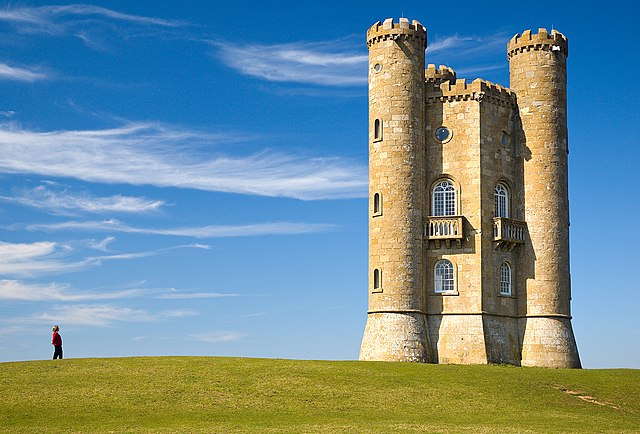

In [4]:
show_pnm("castle.pnm")

In [5]:
!nvcc -arch=sm_{major}{minor} sequentially.cu -o sequentially --disable-warnings

In [6]:
!./sequentially castle.pnm out 300 


Image size (width x height): 640 x 434
Host version - Number of seams = 300 - Kernel time = 20110.414062 ms


Kích thước hình ảnh: 340 x 434


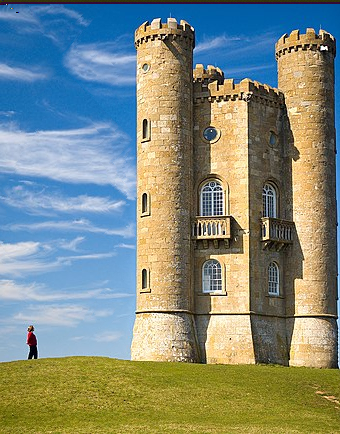

In [7]:
show_pnm("out_host.pnm")

Nhận xét:
- Thuật toán thực hiện thành công, ảnh output có kích thước *340 x 434* như kì vọng và vẫn giữ được hai điểm quan trọng nhất là người phụ nữ và toà lâu đài.
- Thời gian chạy hàm Seam Carving: ~ 18000 ms

# Cài đặt song song

## Phân tích

- Các bước thực hiện song song hoá:
 - Chuyển đổi ảnh RGB sang ảnh Grayscale.
   - Mục đích: tăng tốc độ chuyển đổi.
 - Song song hoá hàm tính độ quan trọng của mỗi pixel.
   - Mục đích: gộp chung tính toán tích chập với xSobel, ySobel trong 1 hàm, giảm số lượng vòng lặp.
 - Song song hoá bước tìm đường *seam* có độ quan trọng ít nhất.
   - Mục đích: tăng tốc độ thực hiện thuật toán, vì thuật toán quy hoạch động tiêu tốn rất nhiều chi phí tính toán.
 - Xoá *seam* có độ quan trọng ít nhất ra khỏi ảnh gốc.
   - Mục đích: tăng tốc độ của thuật toán

## Thiết kế

- Viết hàm *convertRgb2GrayKernel* để song song hoá bước chuyển ảnh sang Grayscale
- Viết hàm *calcPixelImportanceKernel* để tính độ quan trọng của mỗi pixel, hàm này gộp chung tính tích chập với **xSobel, ySobel** để giảm số lần lặp
- Viết hàm *calcMinValAndKeepTrackKernel* để tính toán một hàng của ma trận **trackCol** và đường đi của tất cả các *seam*. Ở hàm này với mỗi dòng của ma trận độ quan trọng của các pixel, gọi hàm kernel truyền vào dòng này và dòng ngay bên dưới nó để có thể tính toán quy hoạch động.
- Viết hàm *removeSeamKernel* để xoá seam có độ quan trọng ít nhất ra khỏi ảnh gốc.

- Kịch bản thí nghiệm:
 - **File ảnh**: *castle.pnm*
 - **Input**: hình ảnh có kích thước là 640 x 434, số lượng **seam** sẽ xoá đi là 300.
 - **Output**: hình ảnh có kích thước là 340 x 434 (giảm 300 đơn vị chiều ngang so với input)
 - **Kì vọng**: tốc độ thực thi sẽ cao hơn so với thực hiện tuần tự.

In [8]:
!nvcc -arch=sm_{major}{minor} parallel1.cu -o parallel1 --disable-warnings

In [9]:
!./parallel1 castle.pnm out 300

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Device version 1 - Number of seams = 300 - Kernel time = 7433.077148 ms


Kích thước hình ảnh: 340 x 434


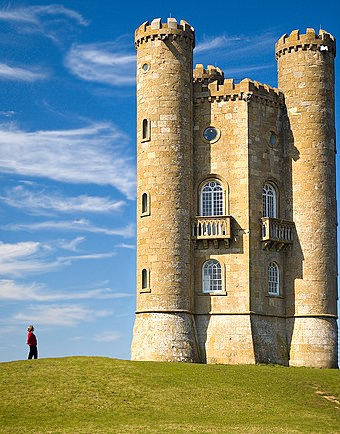

In [10]:
show_pnm("out_device1.pnm")

Nhận xét:
- Thuật toán thực hiện thành công, ảnh output có kích thước *340 x 434* như kì vọng và vẫn giữ được hai điểm quan trọng nhất là người phụ nữ và toà lâu đài.
- Thời gian chạy hàm *Seam Carving*: ~ 7000 ms
- Có thể thấy thời gian chạy phiên bản song song nhanh hơn so với phiên bản tuần tự, tuy nhiên tốc độ thực hiện hàm *Seam Carving* có vẻ vẫn chưa được tối ưu bởi vì bước tìm **seam** có độ quan trọng ít nhất cần phải cấp phát bộ nhớ và copy dữ liệu quá nhiều lần.

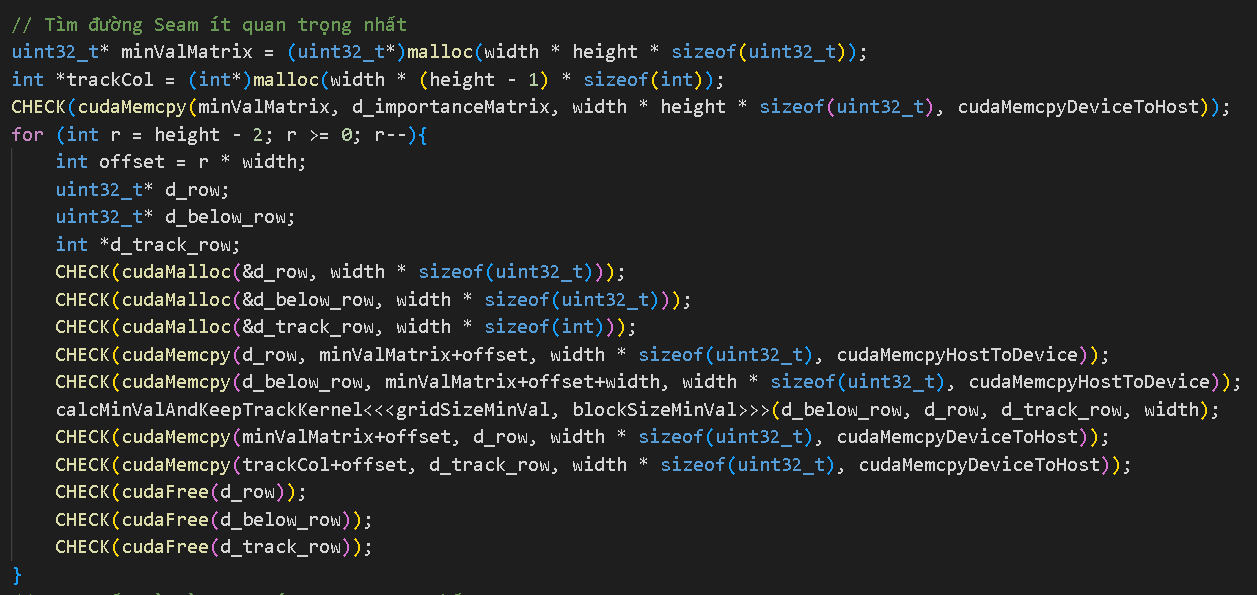

# Cài đặt song song + tối ưu hoá

## Phân tích

- Các bước tối ưu hoá:
 - Như đã trình bày ở version device 1,bước tìm seam có độ quan trọng ít nhất cần phải cấp phát bộ nhớ và copy dữ liệu quá nhiều lần.
 - Vẫn thực hiện tính độ quan trọng của **seam** theo từng dòng, tuy nhiên thay vì liên tục cấp phát và copy dữ liệu của dòng đang xét và dòng bên dưới nó, ta chỉ xét tới dòng đang xét thông qua giá trị *row* và liên tục cập nhập mảng đường đi của **seam**. Sau mỗi vòng lặp, một dòng của ma trận đường đi được tính hoàn chỉnh.

## Thiết kế

- Viết hàm *calcMinValAndKeepTrackKernel* nhận vào giá trị *r* là dòng đang xét tới, thực hiện quy hoạch động tại điểm đó để cập giá trị của điểm đó đồng thời cập nhập giá trị *trackCol* tại điểm đó để lưu vết.

- Kịch bản thí nghiệm:
 - **File ảnh**: *castle.pnm*
 - **Input**: hình ảnh có kích thước là 640 x 434, số lượng **seam** sẽ xoá đi là 300.
 - **Output**: hình ảnh có kích thước là 340 x 434 (giảm 300 đơn vị chiều ngang so với input)
 - **Kì vọng**: tốc độ thực thi sẽ cao hơn so với phiên bản Device 1.

In [11]:
!nvcc -arch=sm_{major}{minor} parallel2.cu -o parallel2 --disable-warnings

In [12]:
!./parallel2 castle.pnm out 300

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Device version 2 - Number of seams = 300 - Kernel time = 1023.460327 ms


Kích thước hình ảnh: 340 x 434


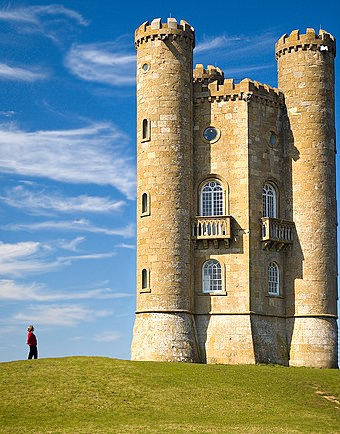

In [13]:
show_pnm("out_device2.pnm")

Nhận xét:
- Thuật toán thực hiện thành công, ảnh output có kích thước *340 x 434* như kì vọng và vẫn giữ được hai điểm quan trọng nhất là người phụ nữ và toà lâu đài.
- Thời gian chạy hàm *Seam Carving*: ~ 1000 ms
- Có thể thấy thời gian chạy phiên bản song song 2 nhanh hơn rất nhiều so với phiên bản song song, kết quả thực thi vẫn chính xác.
- Về phương pháp thực hiện song song hoá, vẫn tuân thủ theo các bước đề ra và kết quả tốt hơn nhiều so với các phiên bản trước.

# TỔNG KẾT

| <font size="5"> Phiên bản </font>|<font size="5"> Thời gian </font>|
|:-------------------:|-----------------------:|
|<font size="4"> Version 1 host (sequentially)</font>   | <font size="3"> ~ 18000 ms</font>  
| <font size="4"> Version 2 kernel (parallel)</font> | <font size="3"> ~ 7000 ms</font>         |
| <font size="4"> Version 3 kernel (parallel + optimization)</font> |    <font size="3"> ~ 1000 ms  </font>         |     <font size="3">  0.65634  </font>       |

# NHÌN LẠI QUÁ TRÌNH LÀM ĐỒ ÁN

## Hoàng Văn Quang
- **Difficulties**:
 - Synchronizing the threads in parallel
 - A long time for the idea to upgrade the code
 - Parallelize the code for the idea of an error
- **Learned**:
 - Understand seam algorithm
 - Better understand how to parallelize

## Tô Vũ Thái Hào
- **Difficulties**:
 - Finding a different way to upgrade the code
 - Synchronizing the threads 
 - Implementing the upgrading ideas
 - Bad time management
- **Learned**:
 - Understand seam algorithm
 - Understand how to use cuda memory

## Lê Tấn Đạt
- **Difficulties**:
 - Having trouble using SMEM
 - Colab limits GPU Kernel usage time 
 - Implementing the optimize parallel ideas
 - Working time is limited due to other subjects
- **Learned**:
 - Understand seam algorithm clearly
 - Understand how to use cuda memory more efficiently
 - Different ways to optimize a problem

## Phương án cải thiện bài toán trong tương lai
- Áp dụng **SMEM** để xử lí hàm tính tích chập nhằm cải thiện tốc độ thực thi
- Áp dụng cơ chế **stream** để chia nhỏ các hàm kernel
- Dự đoán trước đường **seam** tiếp theo sẽ bị xoá, giảm thiểu khối lượng công việc -> giảm thời gian thực thi

# Tài liệu tham khảo

[Seam Carving Algorithm](http://https://vi.wikipedia.org/wiki/Markdown)

[Seam Carving for Content-Aware Image Resizing](https://perso.crans.org/frenoy/matlab2012/seamcarving.pdf)

[Optimized Image Resizing Using Seam Carving and Scaling](https://hal.inria.fr/inria-00515515/document)

[Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator)